In [20]:
from soundscape_IR.soundscape_viewer import audio_visualization
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import scipy
from scipy import signal, interpolate
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import s3fs
import botocore
import os
import glob
from scipy.signal import stft


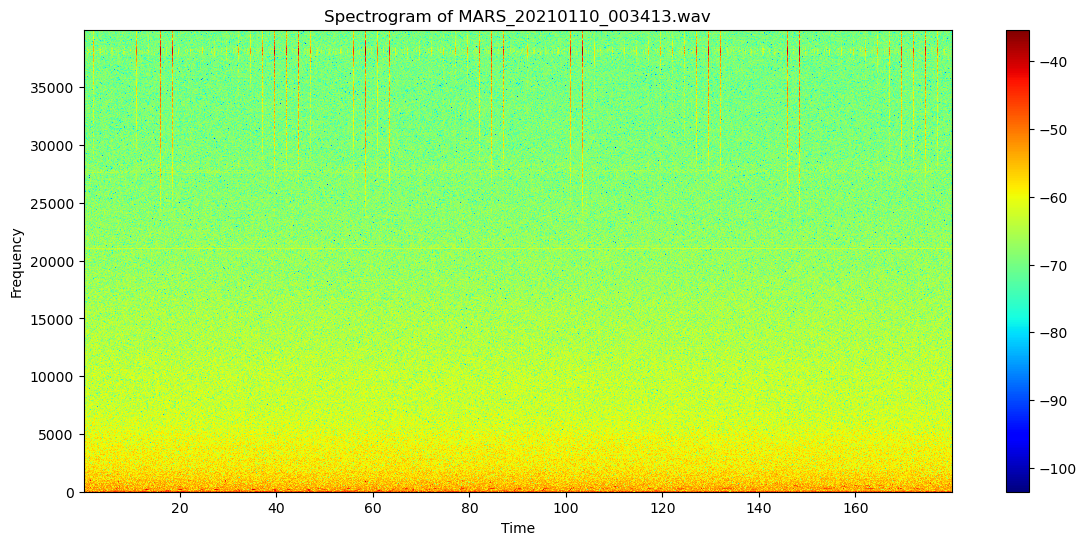

In [63]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210110_003413.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], FFT_size=9290)

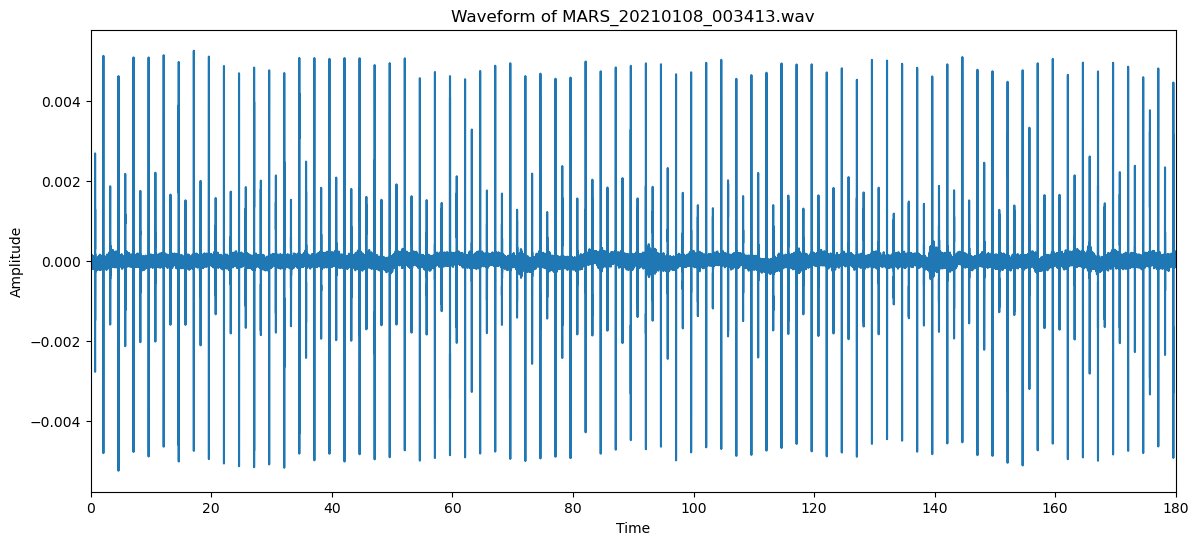

In [34]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210108_003413.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25, plot_type='Waveform')

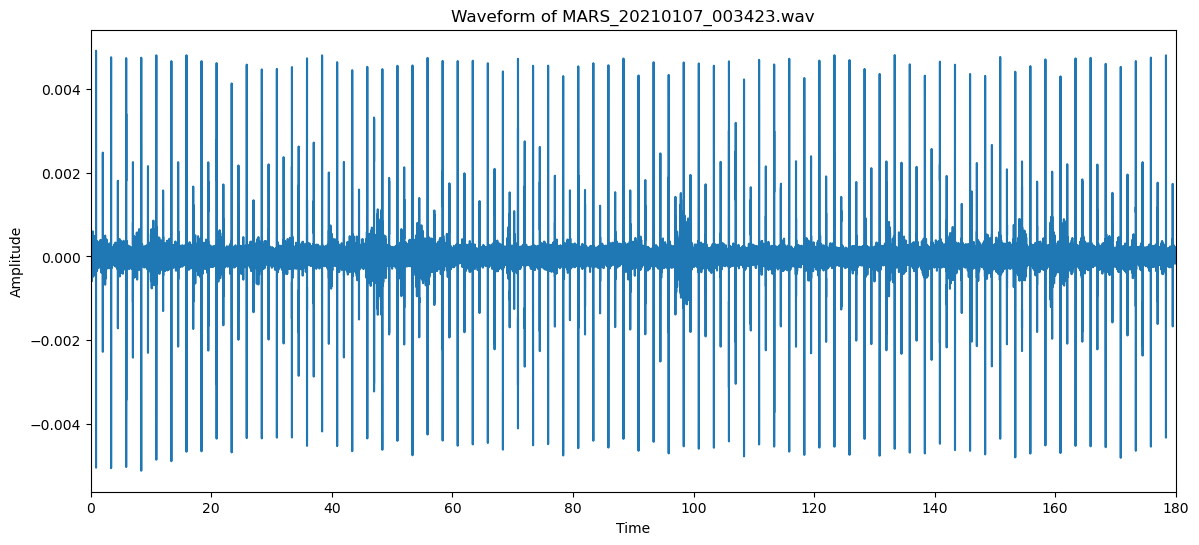

In [38]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210107_003423.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25, plot_type='Waveform')

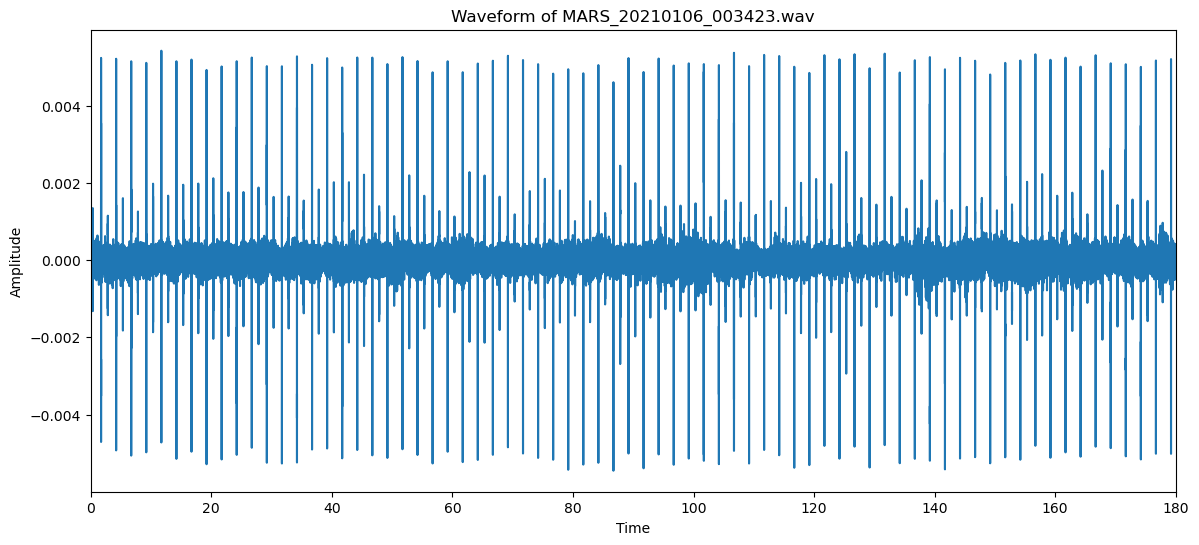

In [35]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210106_003423.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25, plot_type='Waveform')

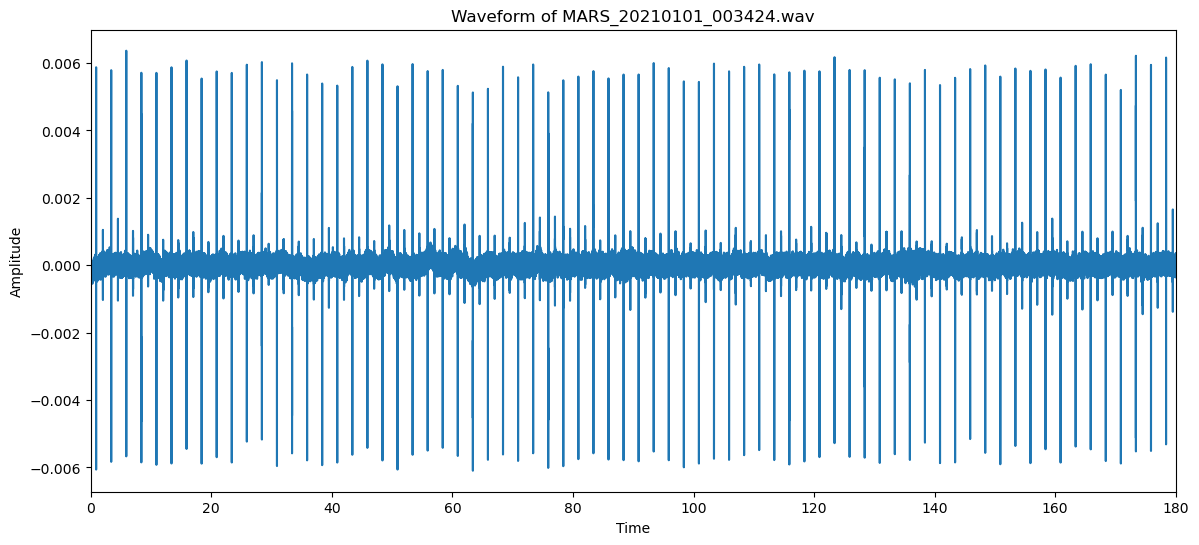

In [36]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210101_003424.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25, plot_type='Waveform')

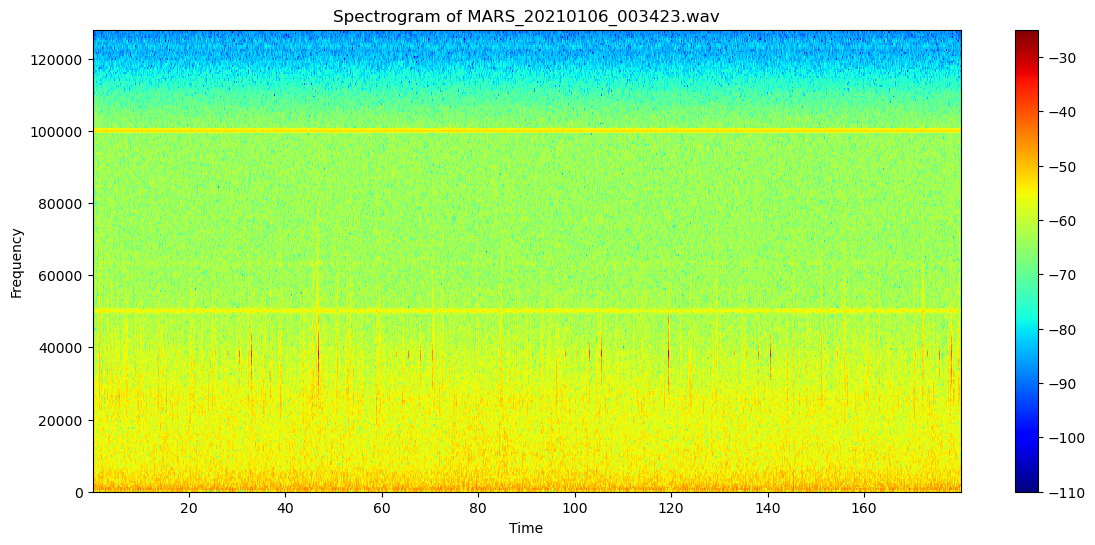

In [71]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210106_003423.wav', duration_read=180, path='./data/california-pam/',
                          vmin=-110, vmax=-25, environment='wat')

In [8]:
import os
import wave

import pylab
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate


### Implementing some spectrogram stuff

Spectrogram is relative between two audio files...

In [56]:
# calibrating long term spectrogram using averages
def CalibLTSA(x, sample_rate):

    # convert scaled voltage to volts
    v = x*3 
    nsec = (v.size)/sample_rate # number of seconds in vector
    spa = 1  # seconds per average
    nseg = int(nsec/spa)
    print(f'{nseg} segments of length {spa} seconds in {nsec} seconds of audio')
            
    # initialize empty LTSA
    nfreq = int(sample_rate/2+1)
    nfreq,nseg
    sg = np.empty((nfreq, nseg), float)
    sg.shape
    
    # get window for welch
    w = scipy.signal.get_window('hann',sample_rate)

    # process spectrogram
    for x in range(0,nseg):
        cstart = x*spa*sample_rate
        cend = (x+1)*spa*sample_rate
        f,psd = scipy.signal.welch(v[cstart:cend],fs=sample_rate,window=w,nfft=sample_rate)
        psd = np.where(psd > 0.0000000001, psd, -10)
        psd = 10*np.log10(psd)
        sg[:,x] = psd
        
    # define hydrophone calibration data
    calfreq = [0,250,10000,20100,30100,40200,50200,60200,70300,80300,90400,100400,110400,120500,130500,140500,150600,160600,170700,180700,190700,200000]
    calsens = [-177.90,-177.90,-176.80,-176.35,-177.05,-177.35,-177.30,-178.05,-178.00,-178.40,-178.85,-180.25,-180.50,-179.90,-180.15,-180.20,-180.75,-180.90,-181.45,-181.30,-180.75,-180.30]

    # interpolate to the frequency resolution of the spectrogram
    tck = interpolate.splrep(calfreq, calsens, s=0)
    isens = interpolate.splev(f, tck, der=0)
    
    # replicate interpolated sensitivity
    isensg = np.transpose(np.tile(isens,[nseg,1]))
    
    return sg, isensg # spectrogram & interpolated sensitivity

In [64]:
x, sample_rate = sf.read('data/california-pam/MARS_20210101_003424.wav')

In [65]:
x.shape

(153600000,)

In [66]:
sample_rate

256000

In [67]:
x.shape[0]/sample_rate

600.0

In [68]:
spec, itp_sense = CalibLTSA(x, sample_rate)

600 segments of length 1 seconds in 600.0 seconds of audio


/tmp/ipykernel_58/154801342.py:26: RuntimeWarning: invalid value encountered in log10
  psd = 10*np.log10(psd)


In [32]:
spec.shape

(128001, 600)

In [17]:
itp_sense.shape

(128001, 600)

Text(0.5, 1.0, 'Calibrated spectrum levels')

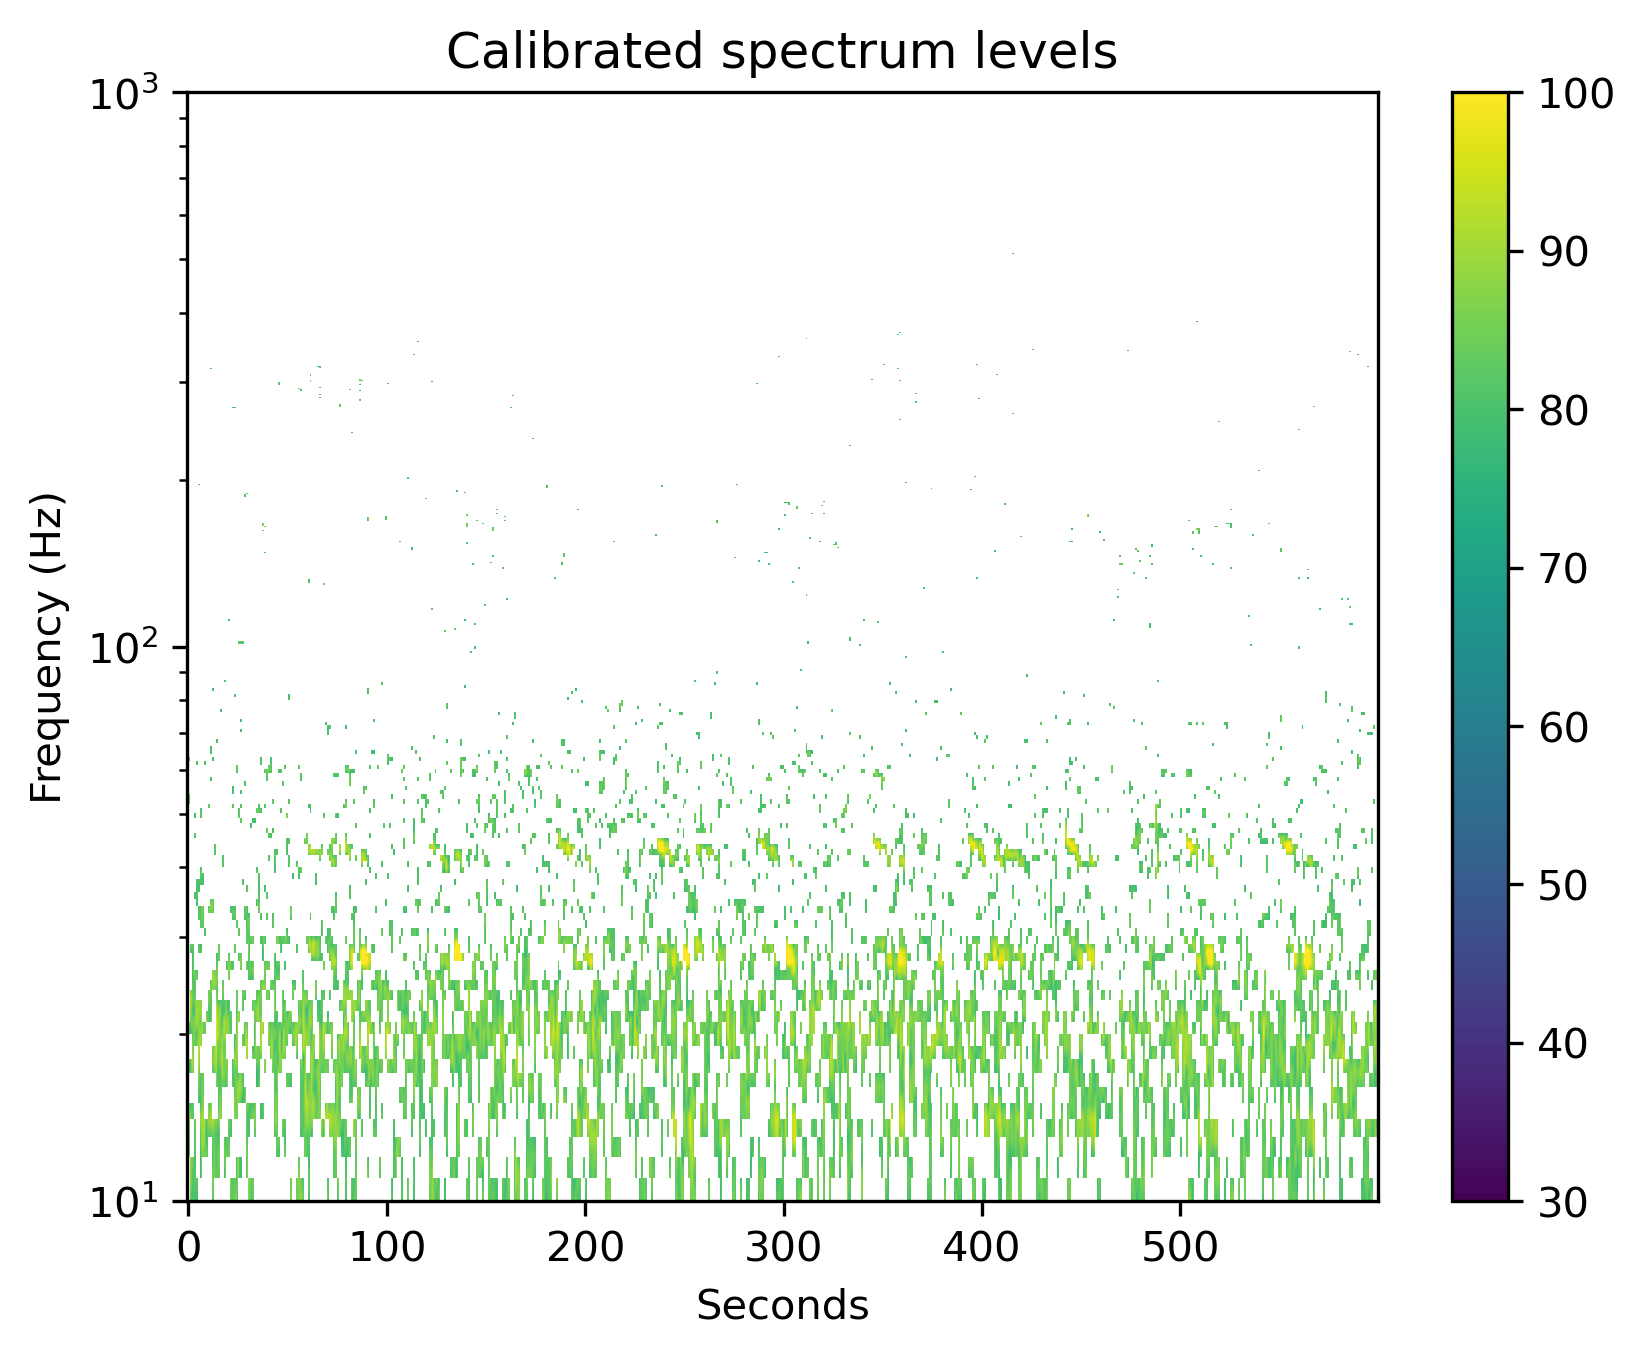

In [69]:
plt.figure(dpi=300)
im = plt.imshow((spec-itp_sense),aspect='auto',origin='lower',vmin=30,vmax=100)
plt.yscale('log')
plt.ylim(10,1000)
plt.colorbar(im)
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')

In [24]:
local_dir='data/california-pam/org_files/'
from soundscape_IR.soundscape_viewer import lts_viewer, lt

LTS_run=lts_maker(sensitivity=0, channel=1, environment='wat', FFT_size=9290, initial_skip=0, time_resolution = 5)
LTS_run.collect_folder(path=local_dir)
LTS_run.filename_check(dateformat='yyyymmdd_HHMMSS',initial='MARS_',year_initial=0)
LTS_run.run(save_filename='LTSA.mat')

Identified  20 files
Example:  MARS_20210101_003424.wav
Please review whether the date and time are retrieved correctly.
Year: 2021
Month: 01
Day: 01
Hour: 00
Minute: 34
Second: 24
Total  20  files, now analyzing file # 20 :  MARS_20210120_003414.wavSuccessifully save to LTSA.mat


In [49]:
LTS=lts_viewer(path='', f_range = [0,120000])

In [51]:
input_data,f=LTS.input_selection('median')
LTS.plot_lts()

AttributeError: 'lts_viewer' object has no attribute 'f'